Plotting /home/minyoungxi/MINYOUNGXI/XFL/UKB_fMRIprep_output/sub-OAS30007/ses-dses/func/sub-OAS30007_ses-dses_task-task_run-02_desc-coreg_boldref.nii.gz
Dimensions: (64, 64, 36)
Voxel Size: (4.0, 4.0, 4.0)


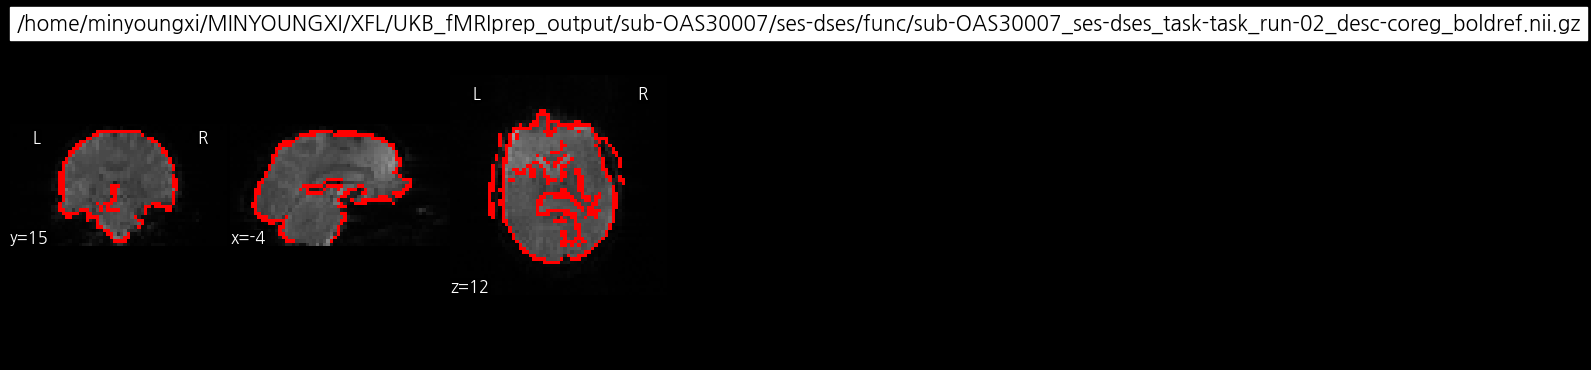

Plotting /home/minyoungxi/MINYOUNGXI/XFL/UKB_fMRIprep_output/sub-OAS30007/ses-dses/func/sub-OAS30007_ses-dses_task-task_run-01_desc-brain_mask.nii.gz
Dimensions: (64, 64, 36)
Voxel Size: (4.0, 4.0, 4.0)


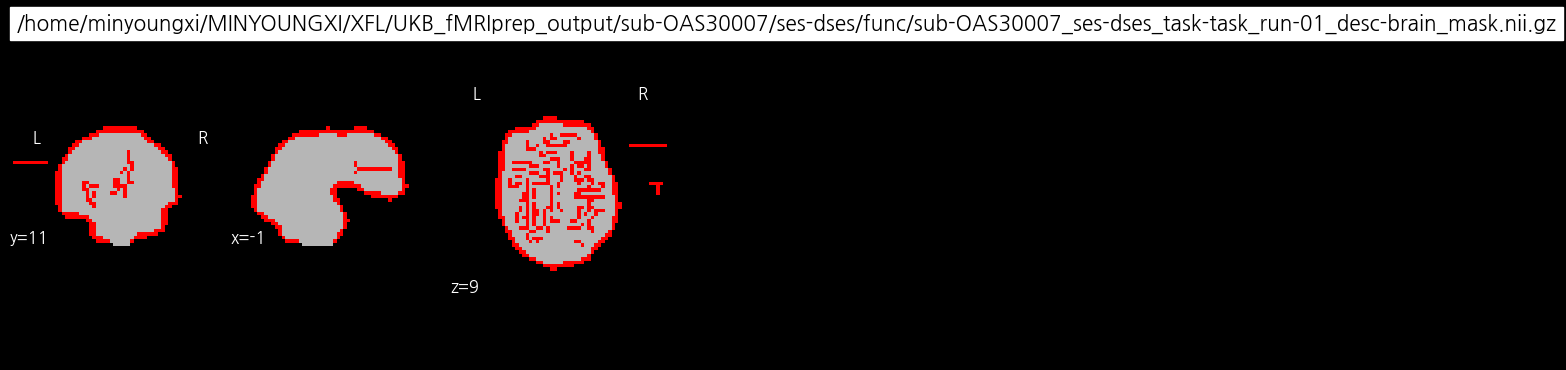

Plotting /home/minyoungxi/MINYOUNGXI/XFL/UKB_fMRIprep_output/sub-OAS30007/ses-dses/func/sub-OAS30007_ses-dses_task-task_run-01_desc-coreg_boldref.nii.gz
Dimensions: (64, 64, 36)
Voxel Size: (4.0, 4.0, 4.0)


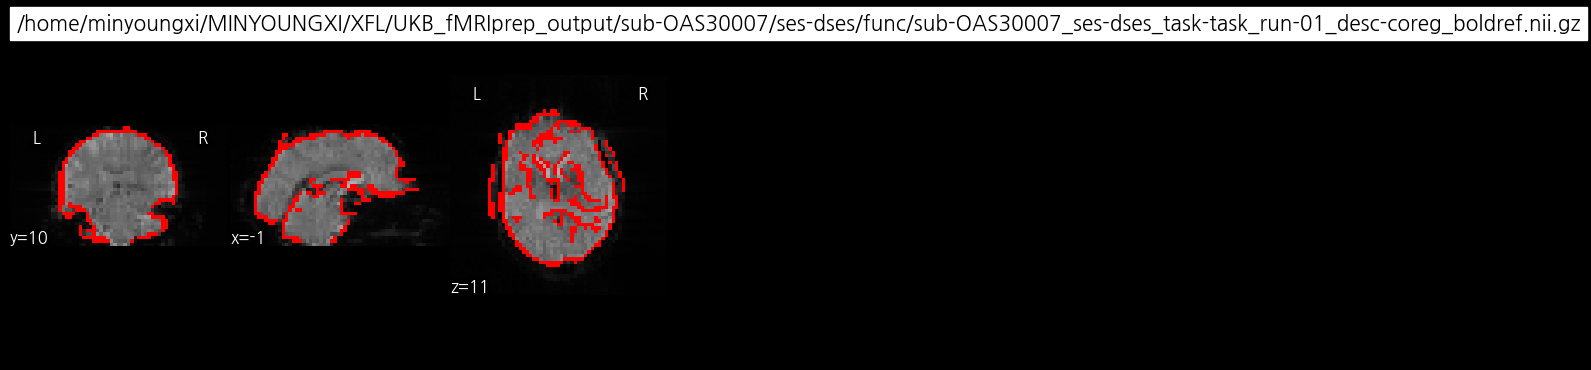

Plotting /home/minyoungxi/MINYOUNGXI/XFL/UKB_fMRIprep_output/sub-OAS30007/ses-dses/func/sub-OAS30007_ses-dses_task-task_run-02_desc-hmc_boldref.nii.gz
Dimensions: (64, 64, 36)
Voxel Size: (4.0, 4.0, 4.0)


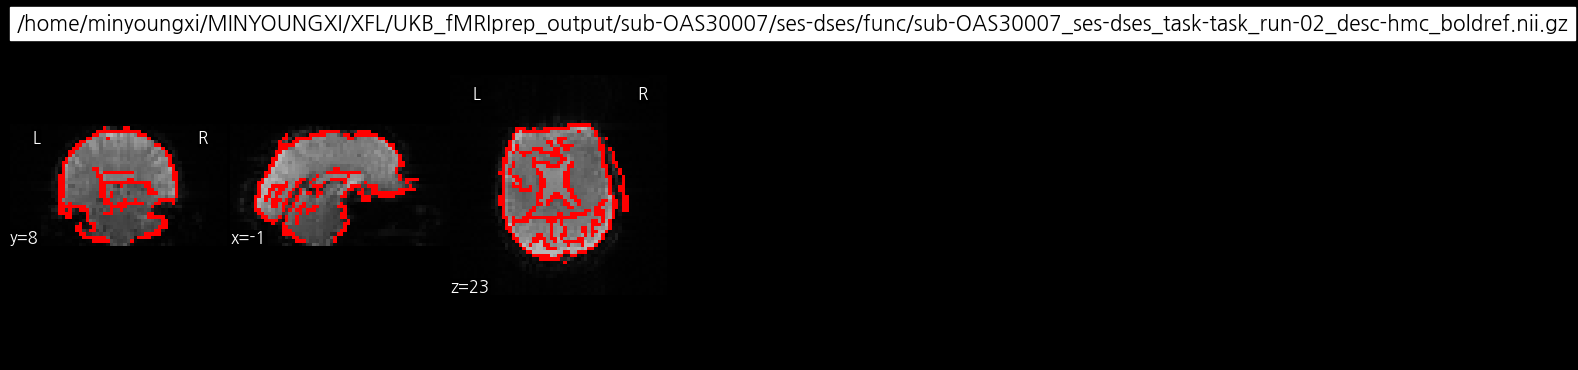

Plotting /home/minyoungxi/MINYOUNGXI/XFL/UKB_fMRIprep_output/sub-OAS30007/ses-dses/func/sub-OAS30007_ses-dses_task-task_run-01_desc-hmc_boldref.nii.gz
Dimensions: (64, 64, 36)
Voxel Size: (4.0, 4.0, 4.0)


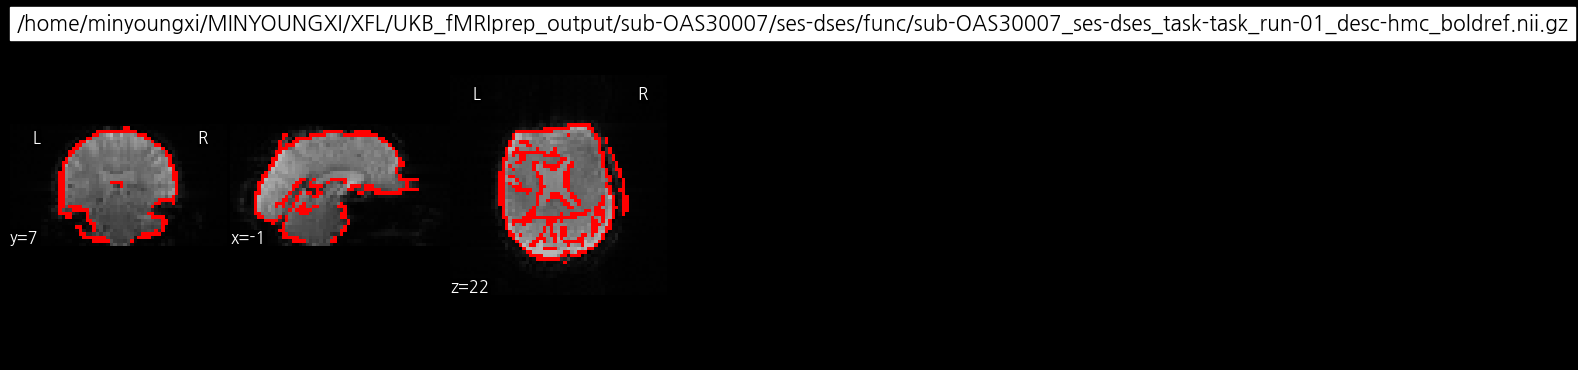

Plotting /home/minyoungxi/MINYOUNGXI/XFL/UKB_fMRIprep_output/sub-OAS30007/ses-dses/func/sub-OAS30007_ses-dses_task-task_run-02_desc-brain_mask.nii.gz
Dimensions: (64, 64, 36)
Voxel Size: (4.0, 4.0, 4.0)


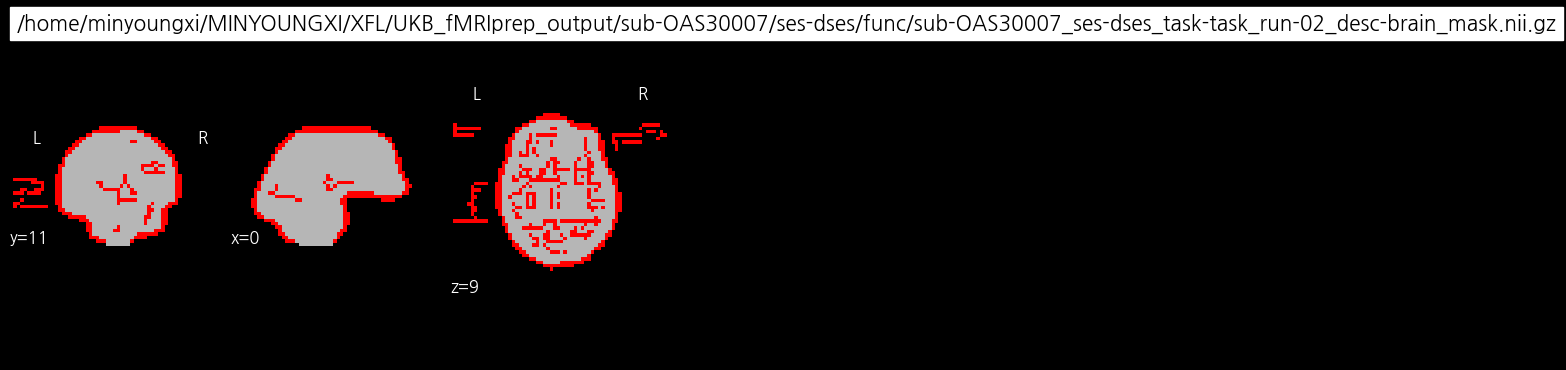

In [2]:
# fMRIprep output

import os
import nibabel as nib
from nilearn import plotting, image

def plot_nii_files(directory):
    subfolders = ['func']
    for subfolder in subfolders:
        path = os.path.join(directory, subfolder)
        if os.path.exists(path):
            for file in os.listdir(path):
                if file.endswith('.nii.gz'):
                    file_path = os.path.join(path, file)
                    # 파일 로드
                    img = nib.load(file_path)
                    # 파일 정보 출력
                    print(f"Plotting {file_path}")
                    print(f"Dimensions: {img.shape}")
                    print(f"Voxel Size: {img.header.get_zooms()}")

                    # 4D 이미지인 경우 평균 이미지 계산
                    if len(img.shape) == 4:
                        img = image.mean_img(img)
                        print("Computed mean image from 4D data.")

                    # 이미지 시각화
                    display = plotting.plot_anat(img, title=file_path, display_mode='ortho', draw_cross=False)
                    display.add_edges(img)
                    plotting.show()

# 함수 사용 예제
plot_nii_files('/home/minyoungxi/MINYOUNGXI/XFL/UKB_fMRIprep_output/sub-OAS30007/ses-dses')

# Nilearn + CuPY

/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


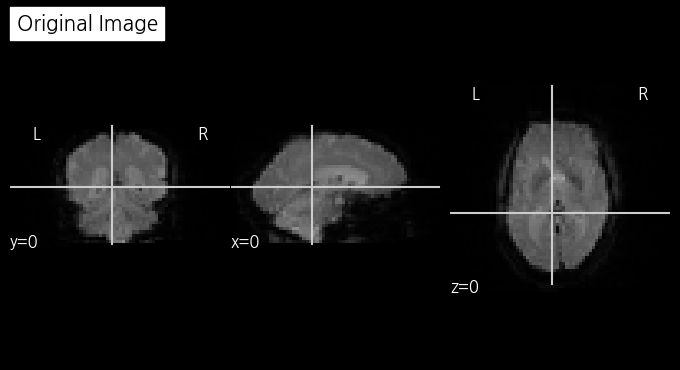

Original Image:
Image shape: (64, 64, 36, 164)
Data type: int16
Voxel size: (4.0, 4.0, 4.000001)
Number of timepoints: 164
-------------------------


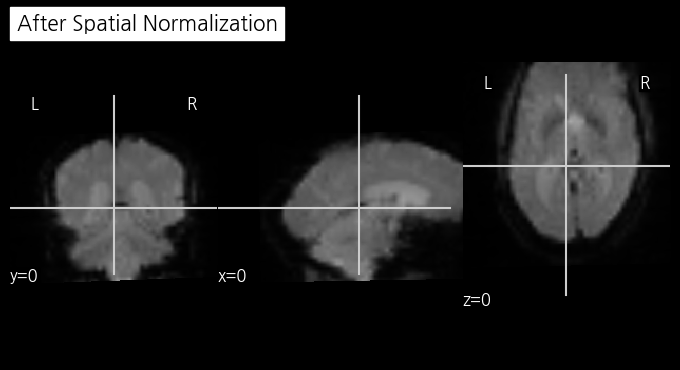

After Spatial Normalization:
Image shape: (197, 233, 189, 164)
Data type: int16
Voxel size: (1.0, 1.0, 1.0)
Number of timepoints: 164
-------------------------


In [10]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import image, masking
from nilearn.datasets import load_mni152_template
from nilearn.plotting import plot_anat
from scipy.ndimage import affine_transform

def plot_slice_with_info(img, title):
    if len(img.shape) == 4:  # 4D 이미지인 경우
        mid_time = img.shape[3] // 2
        img_3d = image.index_img(img, mid_time)
    else:
        img_3d = img
    
    plot_anat(img_3d, display_mode='ortho', cut_coords=(0, 0, 0), title=title)
    plt.show()
    
    print(f"{title}:")
    print(f"Image shape: {img.shape}")
    print(f"Data type: {img.get_data_dtype()}")
    print(f"Voxel size: {img.header.get_zooms()[:3]}")
    if len(img.shape) == 4:
        print(f"Number of timepoints: {img.shape[3]}")
    print("-------------------------")

def load_data(file_path):
    return nib.load(file_path)

def spatial_normalization(img):
    template = load_mni152_template()
    return image.resample_to_img(img, template, interpolation='linear')

def motion_correction(img):
    data = img.get_fdata()
    corrected_data = np.zeros_like(data)
    ref_vol = data[:,:,:,0]
    for i in range(data.shape[-1]):
        shifted = affine_transform(data[:,:,:,i], np.eye(3), [0,0,0], order=3)
        corrected_data[:,:,:,i] = shifted
    return nib.Nifti1Image(corrected_data, img.affine, img.header)

def slice_timing_correction(img, tr):
    return image.slice_time_correction(img, tr=tr, slice_time_ref=0.5)

def brain_extraction(img):
    mask_img = masking.compute_epi_mask(img)
    return image.math_img('img * mask[..., np.newaxis]', img=img, mask=mask_img)

def nuisance_regression(img):
    data = img.get_fdata()
    global_signal = np.mean(data, axis=(0,1,2))
    data_cleaned = data - global_signal[np.newaxis, np.newaxis, np.newaxis, :]
    return nib.Nifti1Image(data_cleaned, img.affine, img.header)

def preprocess_fmri(input_file, tr):
    img = load_data(input_file)
    plot_slice_with_info(img, "Original Image")
    
    img_norm = spatial_normalization(img)
    plot_slice_with_info(img_norm, "After Spatial Normalization")
    
    img_motion = motion_correction(img_norm)
    plot_slice_with_info(img_motion, "After Motion Correction")
    
    img_slice = slice_timing_correction(img_motion, tr)
    plot_slice_with_info(img_slice, "After Slice Timing Correction")
    
    img_brain = brain_extraction(img_slice)
    plot_slice_with_info(img_brain, "After Brain Extraction")
    
    img_clean = nuisance_regression(img_brain)
    plot_slice_with_info(img_clean, "After Nuisance Regression")
    
    return img_clean

# 실행
input_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/UKB_BIDS/sub-31154/ses-dses-d31154/func/sub-OAS31154_ses-d31154_task-task-rest_run-01_bold.nii.gz'
tr = 2.0  # TR (초 단위)

preprocessed_img = preprocess_fmri(input_file, tr)